Discussion 5:

You will be making changes to the starter code for final assignment 2 (Links to an external site.) **to show the effect of multiple alterations on the hidden_layer_sizes parameter for a neural network** (a.k.a. Multi-layer Perceptron in scikit-learn (Links to an external site.)). You will show the results of different image feature set representations on the various performance measures defined by Flach on page 57 (Links to an external site.) and implemented in my_measures.py (Links to an external site.). Changes to the hidden_layer_sizes parameter should be the only variable in your experiment; hold constant all other variables (such as feature set representation and other parameters). 

This assignment is worth 4 points, which is the equivalent of 4% of your final grade. Late submissions will automatically receive 0 points. If in your Jupyter notebook the value for the parameter random_state (also known as my_random_seed in the starter code) is 74, it is an automatic 0 (you can provide any integer value except 74). 

In the Canvas for this course, go to Discussions > Canvas Discussion Assignment 5. Click “Reply” on the main thread to publish your assignment. It should the following:

include one or more graphs/plots that show the result of your work on the assignment (1.5 points)
a short (one or two paragraphs) description of your work and a summary of your results (1.5 points) 
the url to your Jupyter notebook(s) on GitHub (1 point)
Your graph(s) will show multiple comparisons (at least five!) of different values for the hidden_layer_sizes parameter, for both the training and test sets. The input is a tuple (Links to an external site.), which conveys both the number of layers and the number of neurons within each layer. For example, the default value of default=(100,) adds a single hidden layer with 100 neurons in that layer. A tuple of (20, 15, 10) would add three hidden layers, with 20 neurons in the first layer, 15 neurons in the second layer, and 10 neurons in the third layer. 

Your graph(s) should clearly show the result of your experiment for both the training and test sets (one option is to show the ROC plots in the starter code for train and test, for each of the values of alpha, though it would be much more effective if you could display it all in a single graph). Your short (1-2 paragraph description) should clearly summarize the changes you made and why. Include the url to the specific location within your GitHub repository with your Jupyter notebook(s) for this assignment. 

Optional but encouraged: you may reply to others’ postings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
from skimage import io, color, transform, feature, filters
from my_measures import BinaryClassificationPerformance  
from sklearn.model_selection import train_test_split
%matplotlib inline

/Users/janajasa/opt/anaconda3/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


### IMPORTANT!!! Make sure you are using BinaryClassificationPerformance v1.03


In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.03
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

In [3]:
from skimage.feature import corner_foerstner, corner_peaks
square = np.zeros([10, 10])
square[2:8, 2:8] = 1
square.astype(int)

w, q = corner_foerstner(square)
accuracy_thresh = 0.5
roundness_thresh = 0.3
foerstner = (q > roundness_thresh) * (w > accuracy_thresh) * w
corner_peaks(foerstner, min_distance=1)

array([[2, 2],
       [2, 7],
       [7, 2],
       [7, 7]])

2 2
2 7
7 2
7 7


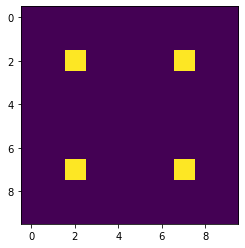

In [4]:
blank_square = np.zeros([10, 10])
for x,y in corner_peaks(foerstner, min_distance=1):
    print(x,y)
    blank_square[x,y]=1
    

plt.imshow(blank_square)
# Draw the image with the detected corners



### file paths and names

In [5]:
ci_path = 'plane_data/cropped_images/' # file path for cropped images for training
l_file = 'plane_data/plane_labels.csv' # file path and file name for csv with labels

# Function for feature building and extraction on photographs¶

scikit-image documentation on methods used for feature extraction:  

* http://scikit-image.org/docs/dev/api/skimage.color.html#rgb2gray  
* http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize  
* http://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.canny

In [6]:
# in downscaling the image, what do you want the new dimensions to be?
# the original dimensions of cropped images: (60, 140), which if 8,400 pixels
dims = (15, 35) # 25% of the original size, 525 pixels

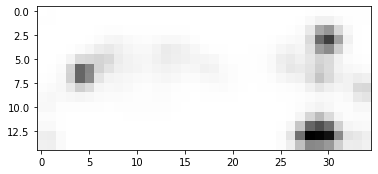

downscaled image shape: 
(15, 35)
image representation (first row of pixels): 
[7.59119111e-04 8.67580578e-04 3.78998086e-04 2.99630813e-04
 2.81276785e-04 1.76330529e-04 9.01993183e-05 4.66298324e-05
 4.52894734e-05 6.86247722e-05 1.11382167e-04 1.64675447e-04
 1.69846869e-04 9.60527634e-05 5.45711574e-05 7.28209232e-05
 1.20488670e-04 2.03549237e-04 2.00768891e-04 1.77881076e-04
 2.48934621e-04 2.47399690e-04 1.43936806e-04 6.46192576e-05
 3.14843995e-05 4.34048904e-05 1.25859189e-04 4.07859248e-04
 1.33430442e-03 3.07671798e-03 3.16390268e-03 1.62038473e-03
 9.96786805e-04 1.15234745e-03 8.91747626e-04]


example of transformation: 


In [7]:
def image_manipulation(imname, imgs_path, imview=False):
    warnings.filterwarnings('ignore')
    imname = imgs_path + imname + '.png'
    img_raw = io.imread(imname, as_gray=True)
    downscaled = transform.resize(img_raw, (dims[0], dims[1])) # downscale image
    final_image = filters.hessian(downscaled, .004) 
#     final_image = filters.hessian(final_image, 0.4, 0.7) 
    final_image = feature.canny(final_image, 9.5) 
    final_image = feature.corner_harris(downscaled, 0.4,9,8) 
    
#     final_image = feature.corner_harris(final_image,0.0005 )
#     help(feature.corner_harris(downscaled, 2, 3, 0.04))
#     class ndarray(builtins.object)
#  |  ndarray(shape, dtype=float, buffer=None, offset=0,
#  |          strides=None, order=None)
    
    if imview==True:
        plt.figure()
        plt.imshow(final_image, cmap='Greys')
        plt.show()
    warnings.filterwarnings('always')
    return final_image

# test the function, look at input/output
# me: changed to matplotlib bc io.imshow doesn't work
test_image = image_manipulation('2017-08-25T23+24+13_390Z', ci_path, True)
print('downscaled image shape: ')
print(test_image.shape)
print('image representation (first row of pixels): ')
print(test_image[0])
print('\n')
print('example of transformation: ')

# Harris Corner+Hessian:

In [8]:
# from skimage import data, segmentation, color
# from skimage.future import graph
# from matplotlib import pyplot as plt
# img = io.imread(ci_path + '2017-08-25T23+24+13_390Z' + '.png', as_gray=True)
# img = transform.resize(img, (dims[0], dims[1])) # downscale image
# hessian = filters.hessian(img)
# # final_image = feature.corner_harris(downscaled, 2, 3, 0.04) # reduce to just corner features
# img.astype(int)
# print(img.shape[0])
# img = feature.canny(img)
# # w, q = corner_foerstner(img)
# # accuracy_thresh = 0.1
# # roundness_thresh = 0.1
# # foerstner = (q > roundness_thresh) * (w > accuracy_thresh) * w
# # corner_peaks(foerstner, min_distance=1)
# # blank_square = np.zeros([img.shape[0],img.shape[1]])
# # for x,y in corner_peaks(foerstner, min_distance=1):
# #     print(x,y)
# #     blank_square[x,y]=1
    
# # blank_square=canny_image+hessian
# plt.imshow(img)


# plt.tight_layout()

# implementing it in a function:


In [9]:
# def my_image_manipulation(imname, imgs_path, imview=False):
#     warnings.filterwarnings('ignore')
#     imname = imgs_path + imname + '.png'
#     img = io.imread(imname, as_gray=True)
#     img = transform.resize(img, (dims[0], dims[1])) # downscale image
# #     img.astype(int)
# #     print(img.shape[0])
#     canny_image = feature.canny(img)
#     hessian = filters.hessian(img)
    
# #     w, q = corner_foerstner(img)
# #     accuracy_thresh = 0.1
# #     roundness_thresh = 0.1
# #     foerstner = (q > roundness_thresh) * (w > accuracy_thresh) * w
# #     corner_peaks(foerstner, min_distance=1)
# #     blank_square = np.zeros([img.shape[0],img.shape[1]])
# #     for x,y in corner_peaks(foerstner, min_distance=1):
# # #         print(x,y)
# #         blank_square[x,y]=1
    

# #     final_image=blank_square+canny_image+hessian
#     final_image = feature.corner_harris(img,  2, 3, 0.04) # reduce to just corner features
# #     final_image = feature.corner_peaks(feature.corner_harris(final_image), min_distance=1)# <- for fun
#     plt.imshow(final_image)


#     plt.tight_layout()
# #     img_raw = io.imread(imname, as_gray=True)
# #     downscaled = transform.resize(img_raw, (dims[0], dims[1])) # downscale image
# #     final_image = feature.canny(downscaled) # edge filter image with Canny algorithm
#     if imview==True:
#         io.imshow(final_image)
#     warnings.filterwarnings('always')
#     return final_image

# # test the function, look at input/output
# test_image = my_image_manipulation('2017-08-25T23+24+13_390Z', ci_path, True)
# print('downscaled image shape: ')
# print(test_image.shape)
# print('image representation (first row of pixels): ')
# print(test_image[0])
# print('\n')
# print('example of transformation: ')

In [10]:
# help(feature.corner_harris(img, 2, 10, 0.04))

# my processor

In [11]:
# def my_image_manipulation(imname, imgs_path, imview=False):
#     warnings.filterwarnings('ignore')
#     imname = imgs_path + imname + '.png'
# #     img_raw = io.imread(imname, as_gray=True)
#     img = io.imread(imname, as_gray=True)

#     labels1 = segmentation.slic(img, compactness=30, n_segments=400,
#                                 start_label=1)
#     out1 = color.label2rgb(labels1, img, kind='avg', bg_label=0)

#     final_image = transform.resize(out1, (dims[0], dims[1])) # downscale image
#     final_image = feature.canny()
# #     final_image = feature.canny(downscaled) # edge filter image with Canny algorithm
#     if imview==True:
#         io.imshow(final_image)
#     warnings.filterwarnings('always')
#     return final_image

# # test the function, look at input/output
# test_image = my_image_manipulation('2017-08-25T23+24+13_390Z', ci_path, True)
# print('downscaled image shape: ')
# print(test_image.shape)
# print('image representation (first row of pixels): ')
# print(test_image[0])
# print('\n')
# print('example of transformation: ')

In [12]:
# for comparison, look at original image:
# this_imname = ci_path + '2017-08-25T23+24+13_390Z.png'
# io.imshow(io.imread(this_imname))

# function to process raw images, resulting in training and test datasets

In [13]:
# function that takes raw images and completes all preprocessing required before model fits
def process_raw_data(labels_fn, images_fp, my_random_seed, imview=False, test=False):
    plane_data = pd.read_csv(labels_fn) # read in photograph labels
    print("First few lines of image labels: ")
    print(plane_data.head())
    print("Size of image label dataFrame: ")
    print(plane_data.shape)
        
    # construct lists for features, labels, and a crosswalk reference to image names
    features_list = []
    if (not test):
        y_list = []
    imnames_list = []

    for index, row in plane_data.iterrows():
#         change thins to implement:
        features_list.append(image_manipulation(row['img_name'], images_fp))
        if (not test):
            y_list.append(row['plane'])
        imnames_list.append(row['img_name'])
    
    # convert the lists to ndarrays
    features = np.asarray(features_list)
    if (not test):
        Y = np.asarray(y_list)
    imgs = np.asarray(imnames_list)
    print('Shape of original feature representation: ')
    print(features.shape)

    # flatten the images ndarray to one row per image
    features_flat = features.reshape((features.shape[0], -1))

    print('Shape of flat feature representation: ')
    print(features_flat.shape)

    if (not test):
        print('Shape of Y: ')
        print(Y.shape)

        print('Number of images with planes: ')
        print(Y.sum())
    
        # create train and test sets
        data_train, data_test, y_train, y_test, imgs_train, imgs_test = train_test_split(features_flat, 
            Y, imgs, test_size = 0.25, random_state = my_random_seed)

        print('Shape of training set: ')
        print(y_train.shape)
        print('Number of training images that contain an airplane: ')
        print(y_train.sum())

        print('Shape of test set: ')
        print(y_test.shape)
        print('Number of test images that contain an airplane: ')
        print(y_test.sum())
    
    if (test):
        X_submission_test = features_flat
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(X_submission_test, plane_data)
    else: 
        print("Shape of data_train and data_test:")
        print(data_train.shape)
        print(data_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of imgs_train and imgs_test:")
        print(imgs_train.shape)
        print(imgs_test.shape)
        print('SUCCESS!')
        return(data_train, data_test, y_train, y_test, imgs_train, imgs_test)


In [14]:
data_train, data_test, y_train, y_test, imgs_train, imgs_test = process_raw_data(l_file, ci_path, 
    my_random_seed=14, imview=False, test=False)

First few lines of image labels: 
                   img_name  plane
0  2016-08-02T13+50+24_430Z  False
1  2016-08-02T14+12+37_390Z  False
2  2016-08-02T22+20+26_600Z  False
3  2016-08-03T12+04+30_670Z  False
4  2016-08-03T12+32+21_790Z  False
Size of image label dataFrame: 
(6758, 2)


/Users/janajasa/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
/Users/janajasa/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issub

Shape of original feature representation: 
(6758, 15, 35)
Shape of flat feature representation: 
(6758, 525)
Shape of Y: 
(6758,)
Number of images with planes: 
101
Shape of training set: 
(5068,)
Number of training images that contain an airplane: 
79
Shape of test set: 
(1690,)
Number of test images that contain an airplane: 
22
Shape of data_train and data_test:
(5068, 525)
(1690, 525)
Shape of y_train and y_test:
(5068,)
(1690,)
Shape of imgs_train and imgs_test:
(5068,)
(1690,)
SUCCESS!


# train Perceptron

In [15]:
#MODEL: Perceptron
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(data_train, y_train)

prc_performance = BinaryClassificationPerformance(prc.predict(data_train), y_train, 'prc')
prc_performance.compute_measures()
prc_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(prc_performance.performance_measures)

prc_performance_test = BinaryClassificationPerformance(prc.predict(data_test), y_test, 'prc')
prc_performance_test.compute_measures()
prc_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(prc_performance_test.performance_measures)

prc_performance_test.img_indices()
prc_img_indices_to_view = prc_performance_test.image_indices

TRAINING SET: 
{'Pos': 79, 'Neg': 4989, 'TP': 52, 'TN': 4975, 'FP': 14, 'FN': 27, 'Accuracy': 0.9919100236779794, 'Precision': 0.7878787878787878, 'Recall': 0.6582278481012658, 'desc': 'prc', 'set': 'train'}
TEST SET: 
{'Pos': 22, 'Neg': 1668, 'TP': 12, 'TN': 1657, 'FP': 11, 'FN': 10, 'Accuracy': 0.9875739644970414, 'Precision': 0.5217391304347826, 'Recall': 0.5454545454545454, 'desc': 'prc', 'set': 'test'}


<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 232 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 232 from PyObject
/Users/janajasa/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Users/janajasa/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprec

In [16]:
def performance_examples(typ, measures):
    iiv = ''
    if typ == 'FP':
        iiv = typ + '_indices'
    elif typ == 'TP':
        iiv = typ + '_indices'
    elif typ == 'FN':
        iiv = typ + '_indices'
    else:
        raise ValueError('input must be "TP", "FP", or "FN"')
    for img in measures[iiv]:
        warnings.filterwarnings('ignore')    
        plt.figure()
        lookat = ci_path + imgs_test[img] + '.png' # location of original image
        io.imshow(lookat) # show original image
        plt.figure()
        io.imshow(data_test[img].reshape(dims[0], dims[1])) # show manipulation for feature representation
        warnings.filterwarnings('always')


# look at examples of Perceptron classifications

## true positives

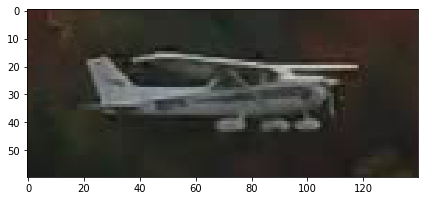

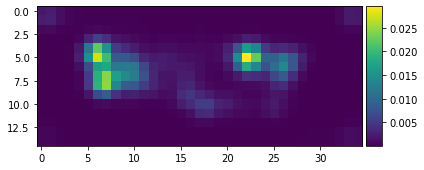

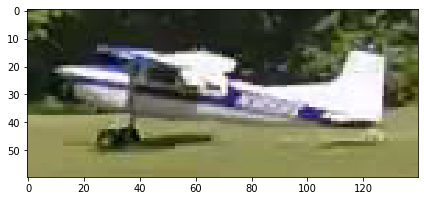

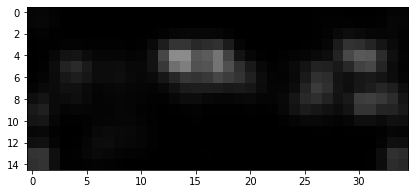

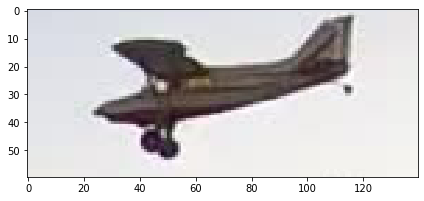

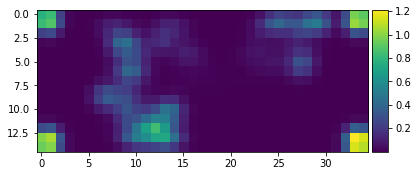

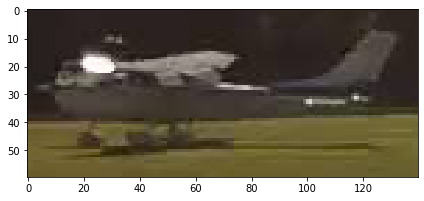

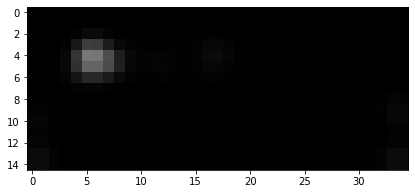

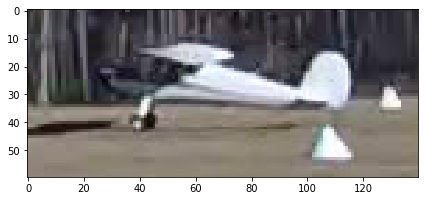

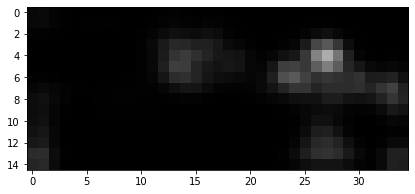

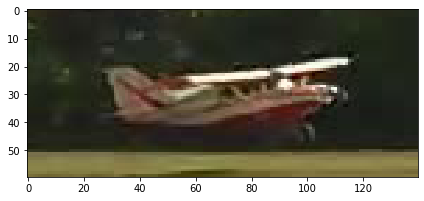

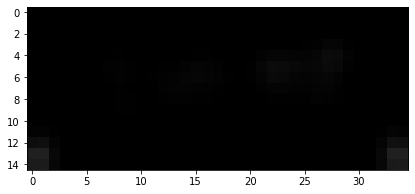

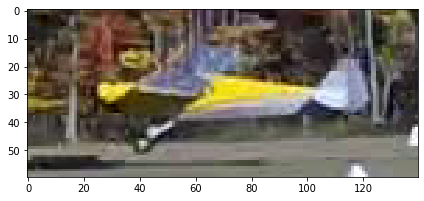

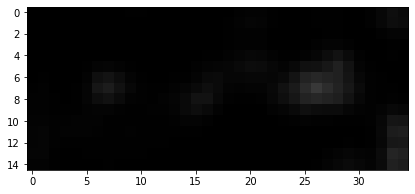

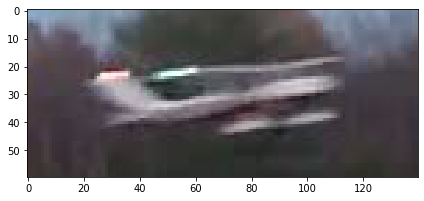

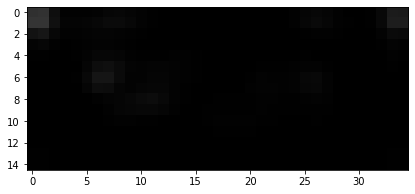

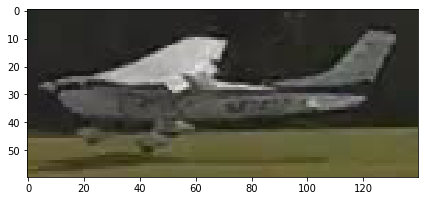

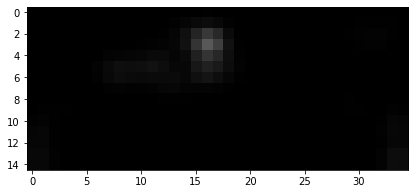

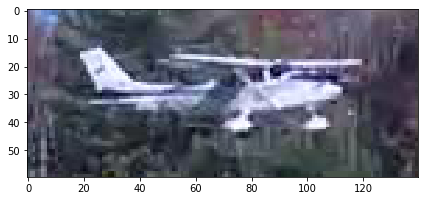

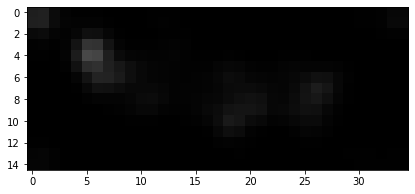

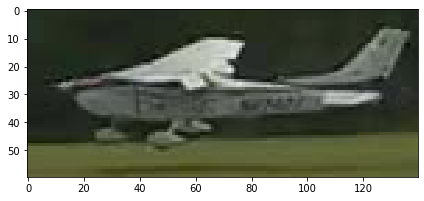

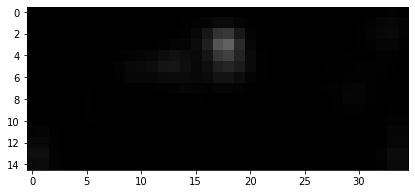

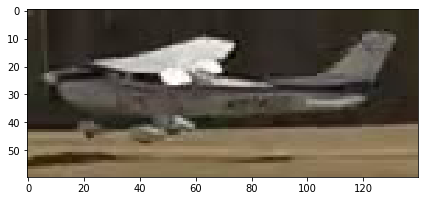

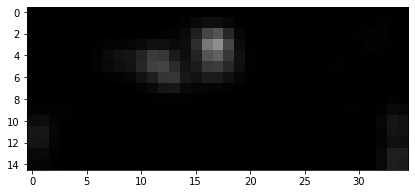

In [17]:
performance_examples('TP', prc_img_indices_to_view)

## false positives

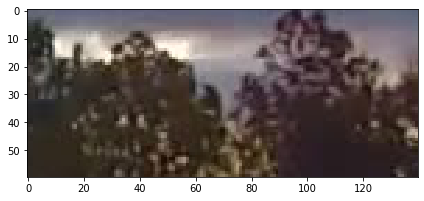

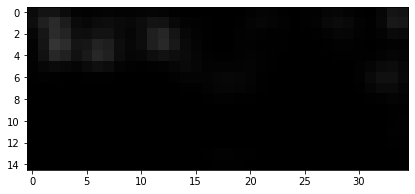

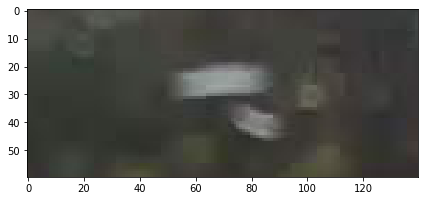

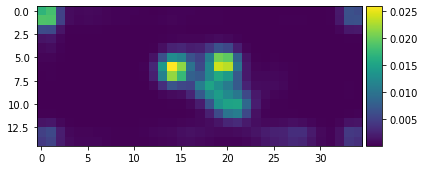

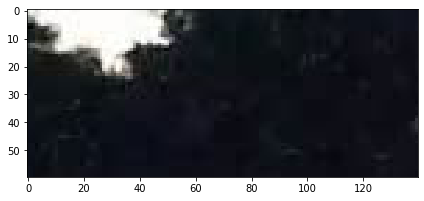

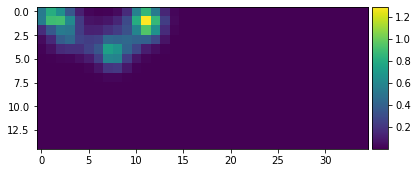

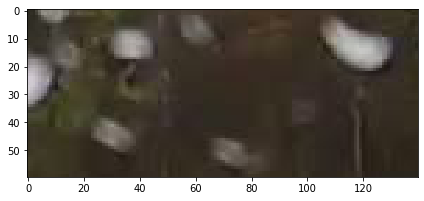

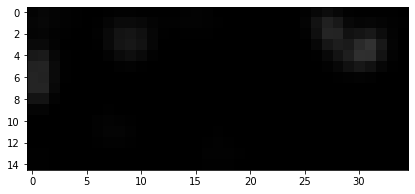

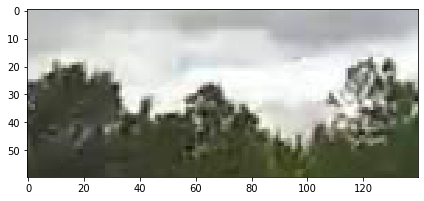

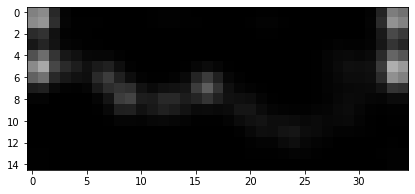

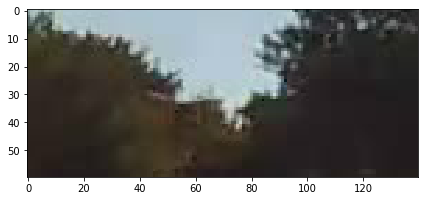

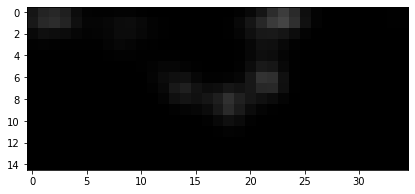

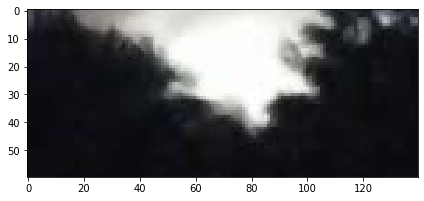

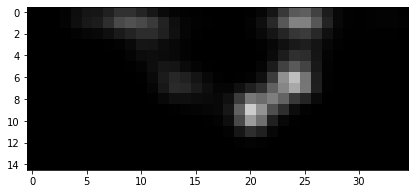

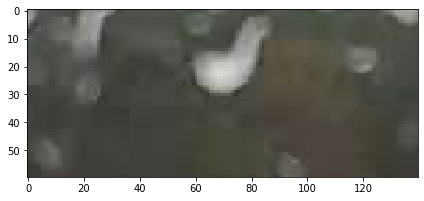

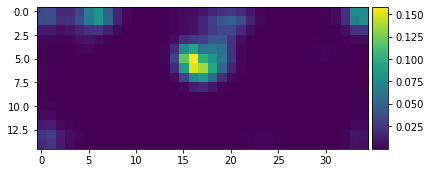

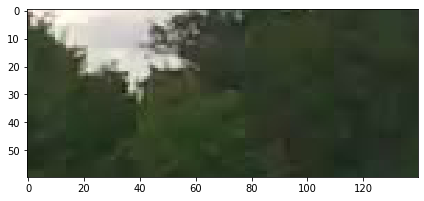

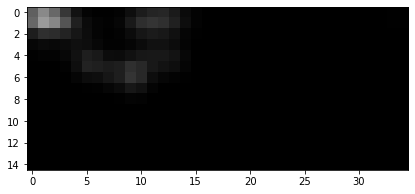

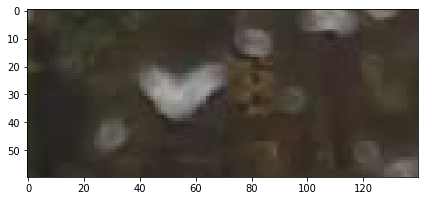

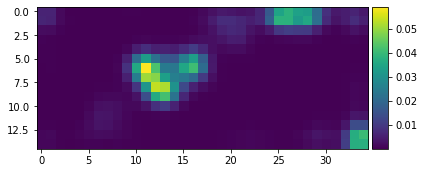

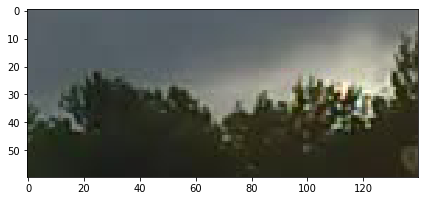

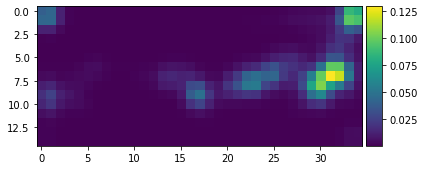

In [18]:
performance_examples('FP', prc_img_indices_to_view)

## false negatives

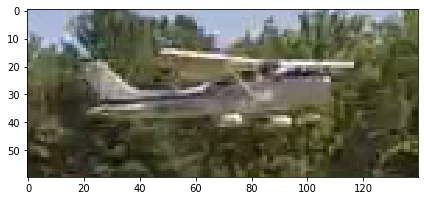

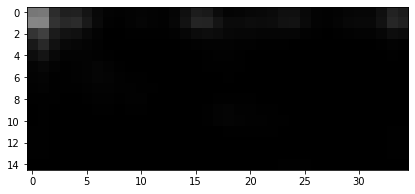

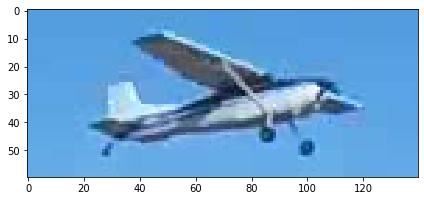

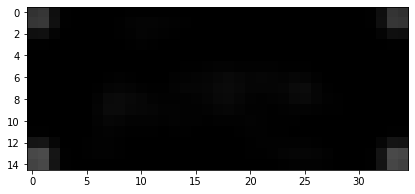

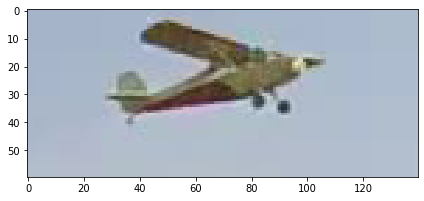

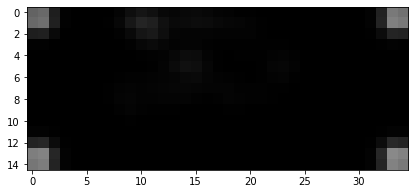

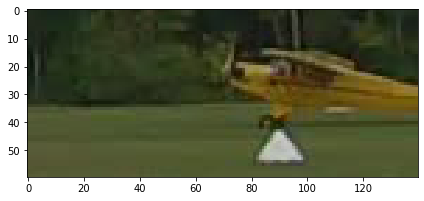

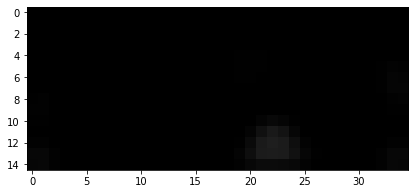

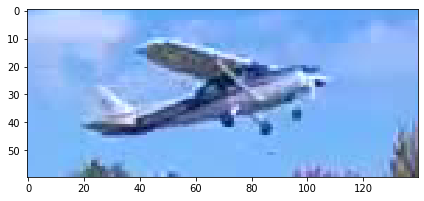

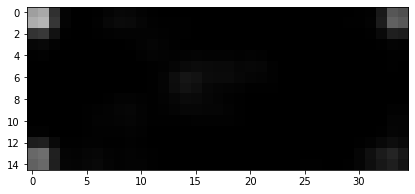

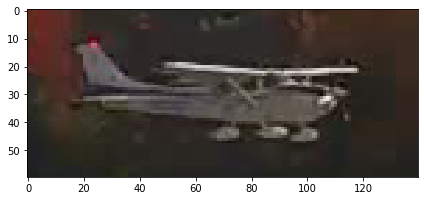

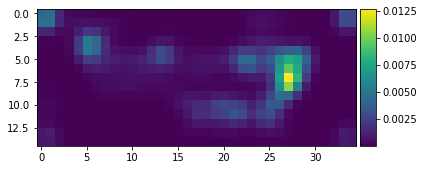

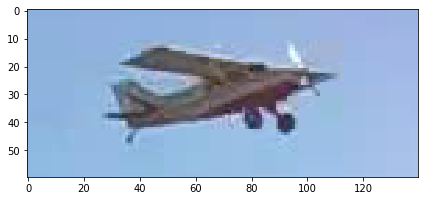

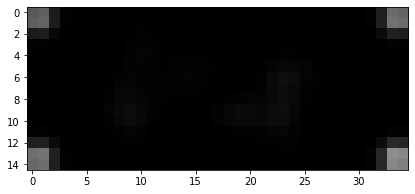

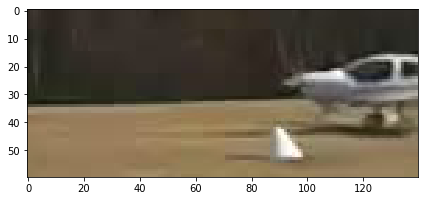

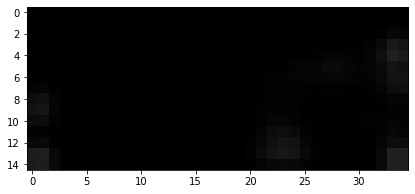

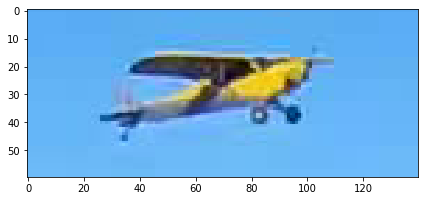

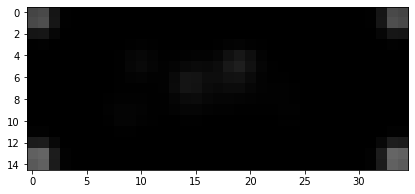

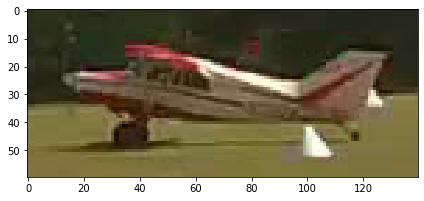

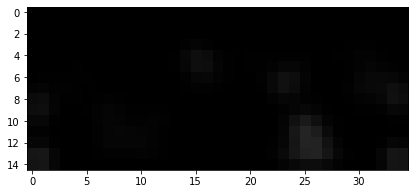

In [19]:
performance_examples('FN', prc_img_indices_to_view)

# train Multilayer Perceptron, a.k.a. neural network

In [20]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(max_iter=1000)
print(nn)
nn.fit(data_train, y_train)

nn_performance = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance.compute_measures()
nn_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance.performance_measures)

nn_performance_test = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test.compute_measures()
nn_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test.performance_measures)

nn_performance_test.img_indices()
nn_img_indices_to_view = nn_performance_test.image_indices

MLPClassifier(max_iter=1000)
TRAINING SET: 
{'Pos': 79, 'Neg': 4989, 'TP': 74, 'TN': 4989, 'FP': 0, 'FN': 5, 'Accuracy': 0.9990134175217048, 'Precision': 1.0, 'Recall': 0.9367088607594937, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 22, 'Neg': 1668, 'TP': 18, 'TN': 1652, 'FP': 16, 'FN': 4, 'Accuracy': 0.9881656804733728, 'Precision': 0.5294117647058824, 'Recall': 0.8181818181818182, 'desc': 'nn_test', 'set': 'test'}


/Users/janajasa/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:775: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.array(y > threshold, dtype=np.int)
/Users/janajasa/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for m

# look at examples of neural network classifications

## true positives

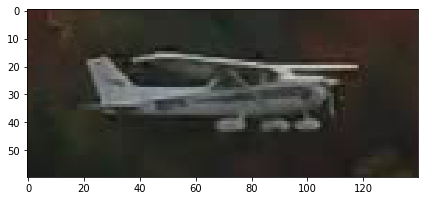

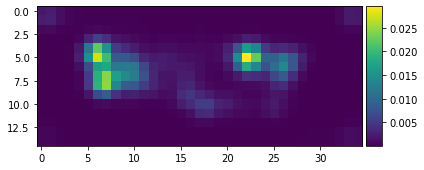

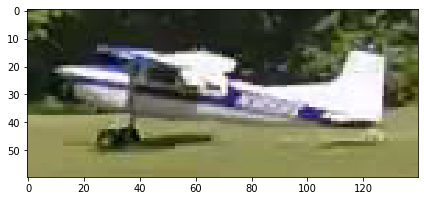

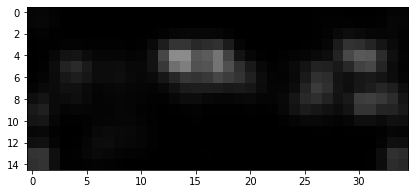

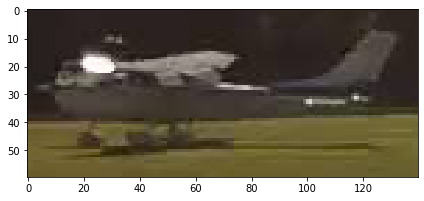

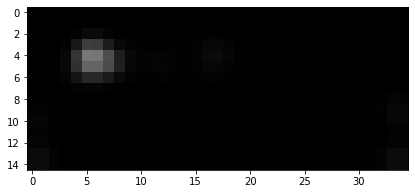

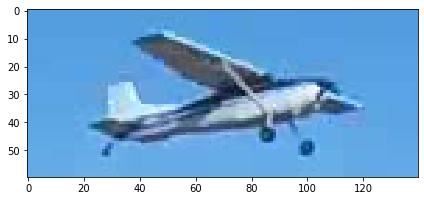

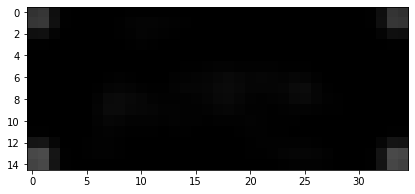

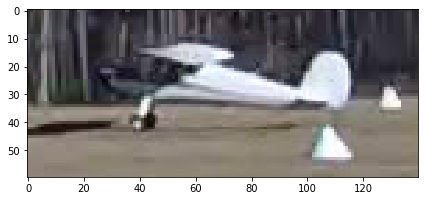

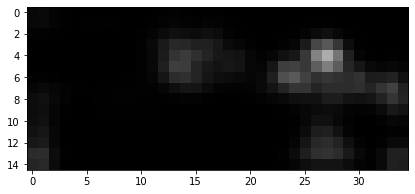

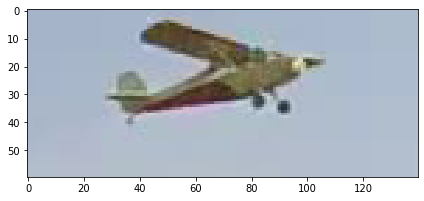

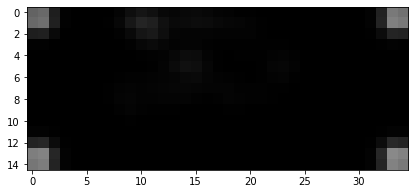

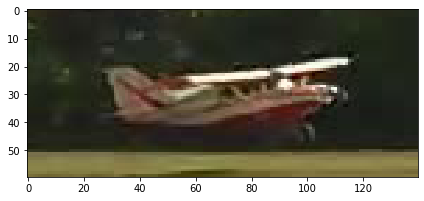

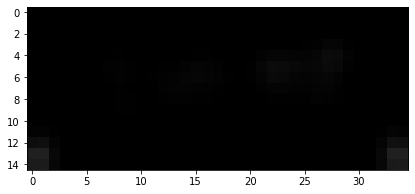

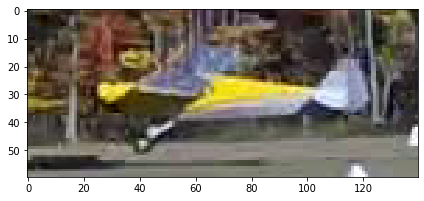

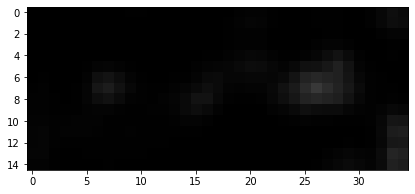

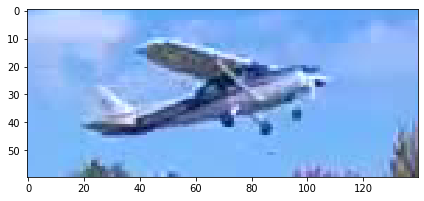

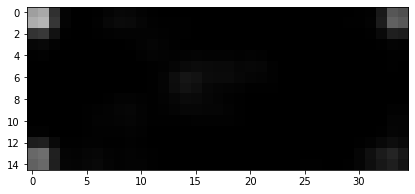

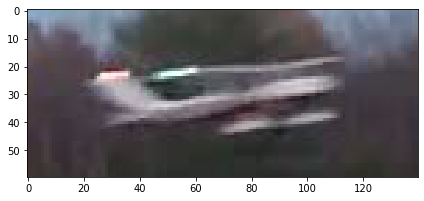

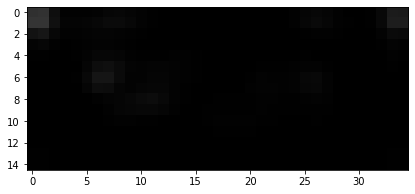

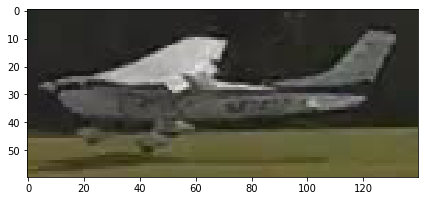

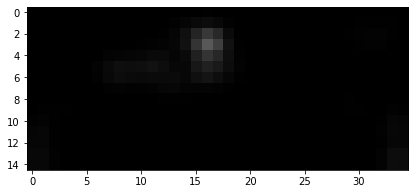

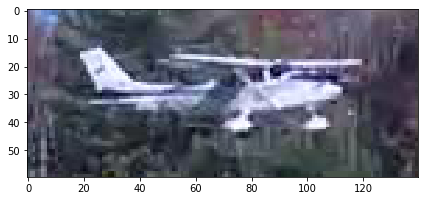

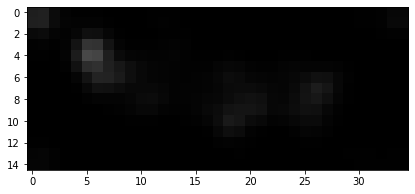

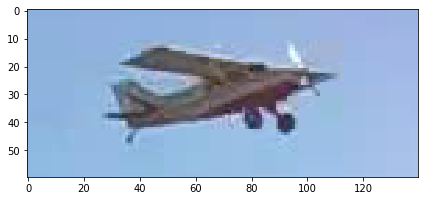

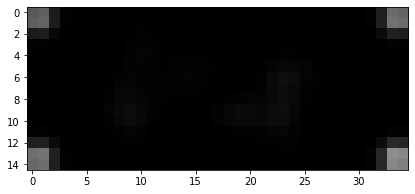

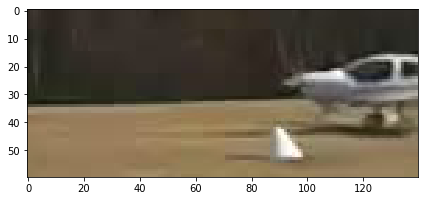

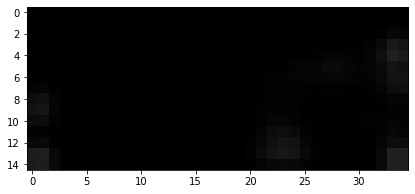

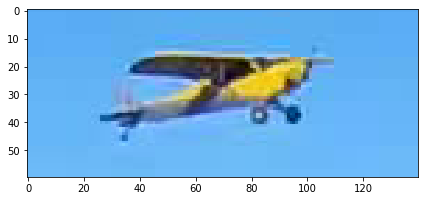

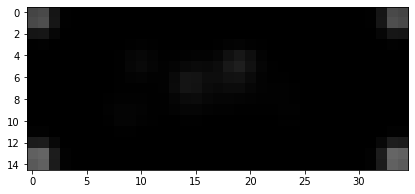

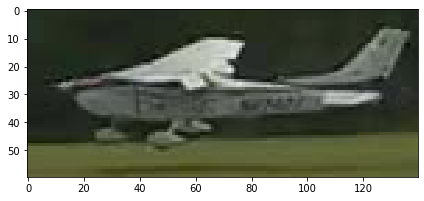

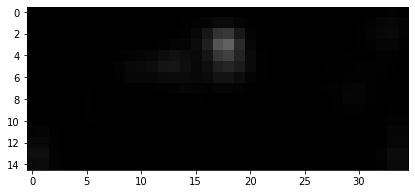

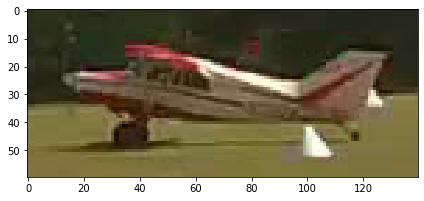

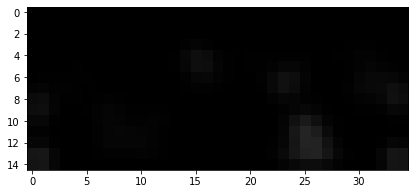

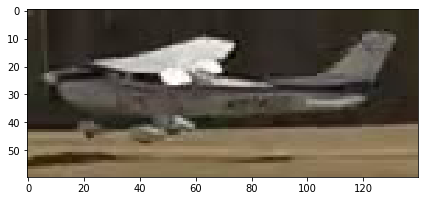

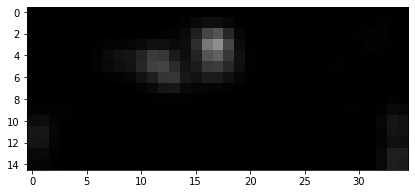

In [21]:
performance_examples('TP', nn_img_indices_to_view)

## false positives

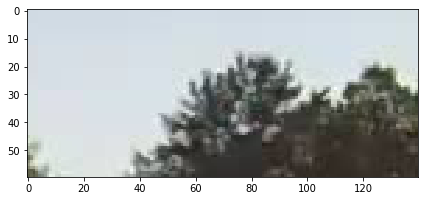

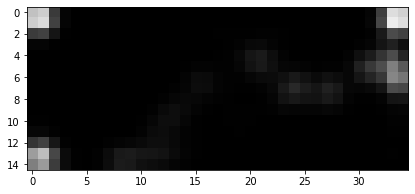

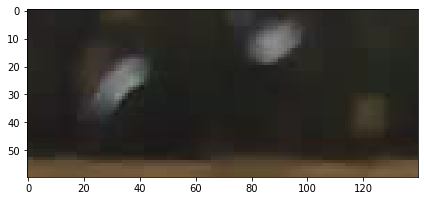

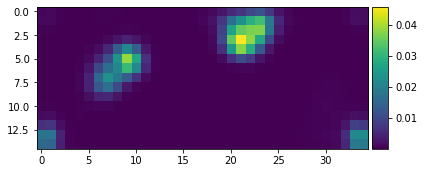

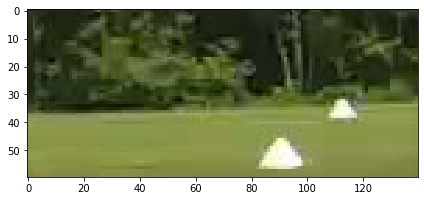

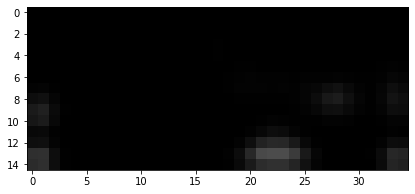

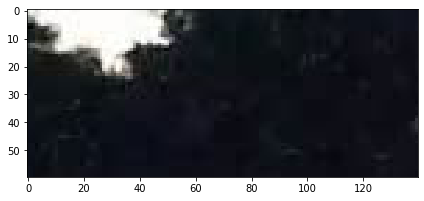

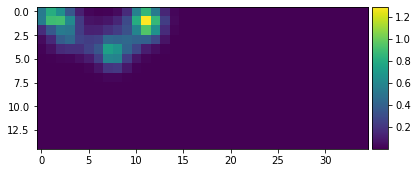

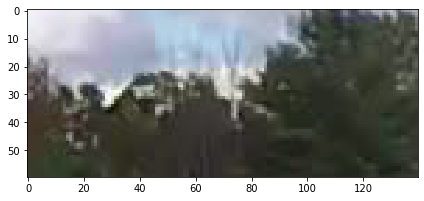

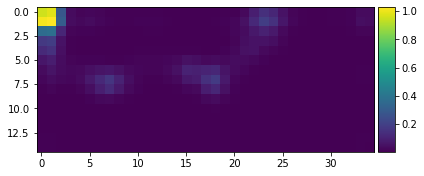

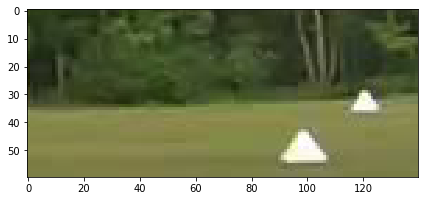

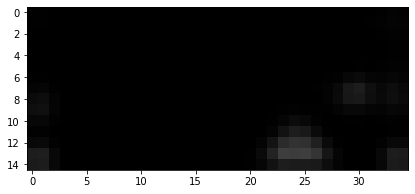

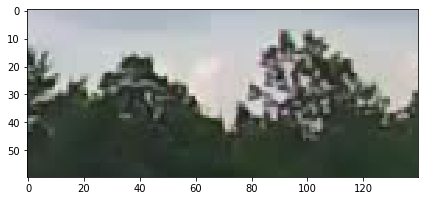

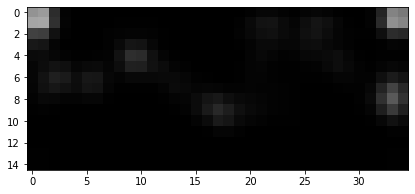

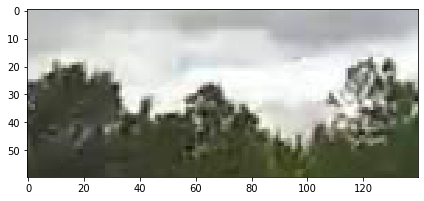

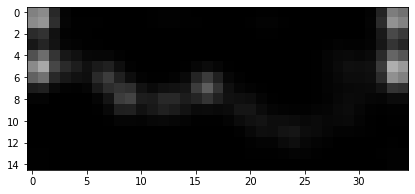

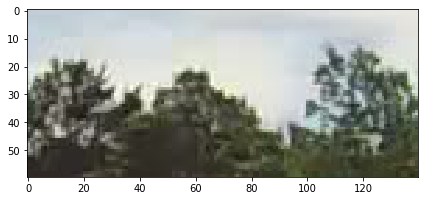

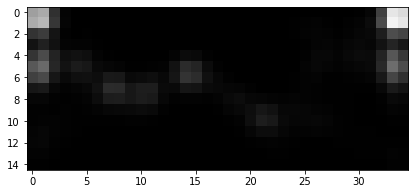

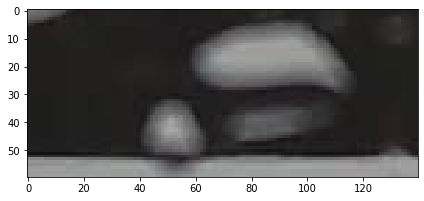

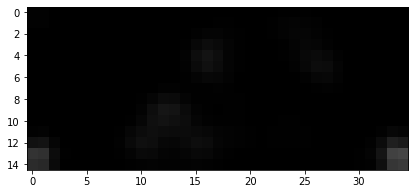

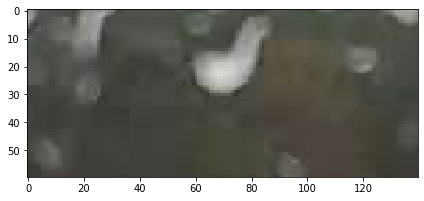

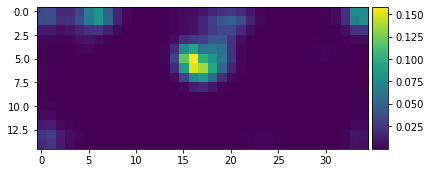

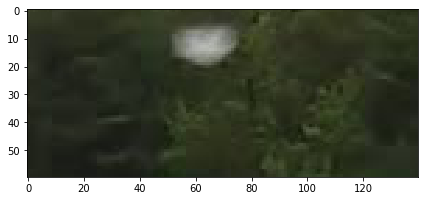

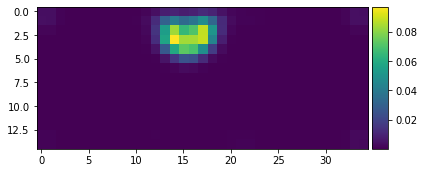

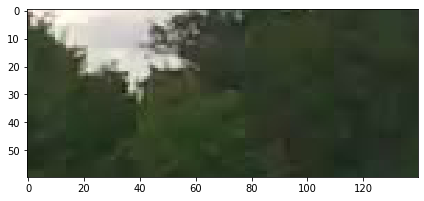

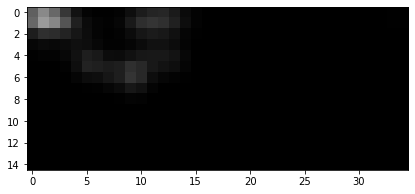

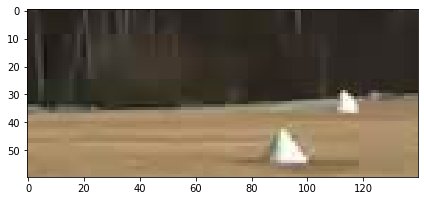

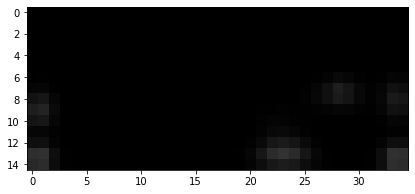

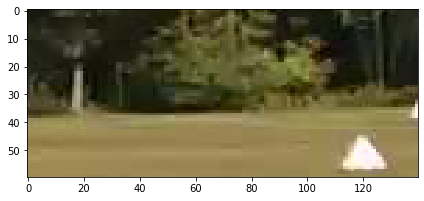

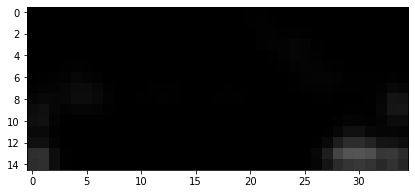

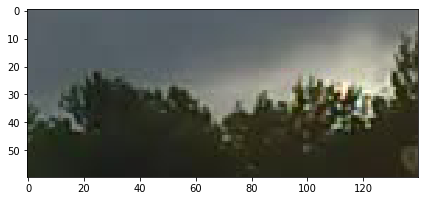

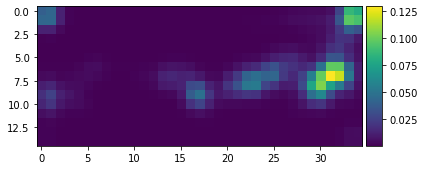

In [22]:
performance_examples('FP', nn_img_indices_to_view)

## false negatives

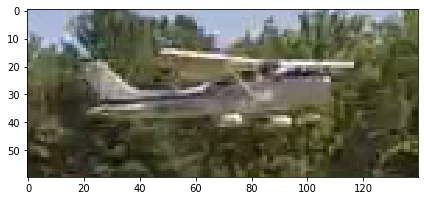

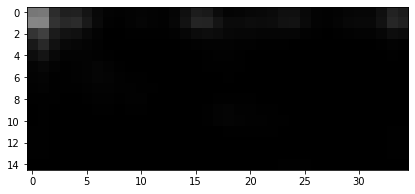

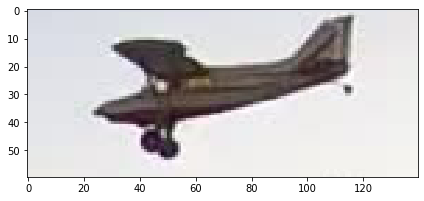

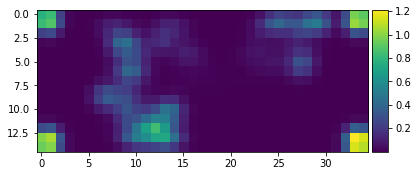

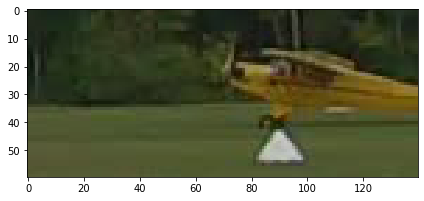

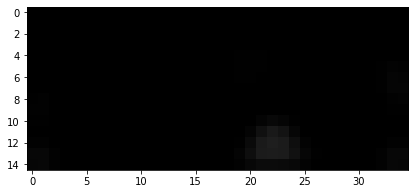

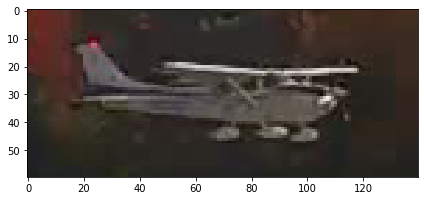

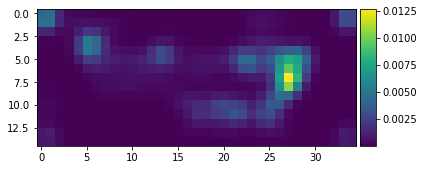

In [23]:
performance_examples('FN', nn_img_indices_to_view)

In [24]:

# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn_iter_2 = neural_network.MLPClassifier(hidden_layer_sizes = (20,10), max_iter=1000)
print(nn_iter_2)
nn_iter_2.fit(data_train, y_train)

nn_iter_2_performance = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn_iter_2')
nn_iter_2_performance.compute_measures()
nn_iter_2_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_iter_2_performance.performance_measures)

nn_iter_2_performance_test = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_iter_2_test')
nn_iter_2_performance_test.compute_measures()
nn_iter_2_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_iter_2_performance_test.performance_measures)

nn_iter_2_performance_test.img_indices()
nn_iter_2_img_indices_to_view = nn_iter_2_performance_test.image_indices

MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=1000)
TRAINING SET: 
{'Pos': 79, 'Neg': 4989, 'TP': 74, 'TN': 4989, 'FP': 0, 'FN': 5, 'Accuracy': 0.9990134175217048, 'Precision': 1.0, 'Recall': 0.9367088607594937, 'desc': 'nn_iter_2', 'set': 'train'}
TEST SET: 
{'Pos': 22, 'Neg': 1668, 'TP': 18, 'TN': 1652, 'FP': 16, 'FN': 4, 'Accuracy': 0.9881656804733728, 'Precision': 0.5294117647058824, 'Recall': 0.8181818181818182, 'desc': 'nn_iter_2_test', 'set': 'test'}


/Users/janajasa/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:775: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.array(y > threshold, dtype=np.int)
/Users/janajasa/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for m

In [25]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn_iter_3 = neural_network.MLPClassifier(hidden_layer_sizes = (50,10), max_iter=1000)
print(nn_iter_3)
nn_iter_3.fit(data_train, y_train)

nn_iter_3_performance = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn_iter_3')
nn_iter_3_performance.compute_measures()
nn_iter_3_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_iter_3_performance.performance_measures)

nn_iter_3_performance_test = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_iter_3_test')
nn_iter_3_performance_test.compute_measures()
nn_iter_3_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_iter_3_performance_test.performance_measures)

nn_iter_3_performance_test.img_indices()
nn_iter_3_img_indices_to_view = nn_iter_3_performance_test.image_indices

MLPClassifier(hidden_layer_sizes=(50, 10), max_iter=1000)
TRAINING SET: 
{'Pos': 79, 'Neg': 4989, 'TP': 74, 'TN': 4989, 'FP': 0, 'FN': 5, 'Accuracy': 0.9990134175217048, 'Precision': 1.0, 'Recall': 0.9367088607594937, 'desc': 'nn_iter_3', 'set': 'train'}
TEST SET: 
{'Pos': 22, 'Neg': 1668, 'TP': 18, 'TN': 1652, 'FP': 16, 'FN': 4, 'Accuracy': 0.9881656804733728, 'Precision': 0.5294117647058824, 'Recall': 0.8181818181818182, 'desc': 'nn_iter_3_test', 'set': 'test'}


/Users/janajasa/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:775: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.array(y > threshold, dtype=np.int)
/Users/janajasa/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for m

In [26]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn_iter_4 = neural_network.MLPClassifier(hidden_layer_sizes = (100,60), max_iter=1000)
print(nn_iter_4)
nn_iter_4.fit(data_train, y_train)

nn_iter_4_performance = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn_iter_4')
nn_iter_4_performance.compute_measures()
nn_iter_4_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_iter_4_performance.performance_measures)

nn_iter_4_performance_test = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_iter_4_test')
nn_iter_4_performance_test.compute_measures()
nn_iter_4_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_iter_4_performance_test.performance_measures)

nn_iter_4_performance_test.img_indices()
nn_iter_4_img_indices_to_view = nn_iter_4_performance_test.image_indices

MLPClassifier(hidden_layer_sizes=(100, 60), max_iter=1000)
TRAINING SET: 
{'Pos': 79, 'Neg': 4989, 'TP': 74, 'TN': 4989, 'FP': 0, 'FN': 5, 'Accuracy': 0.9990134175217048, 'Precision': 1.0, 'Recall': 0.9367088607594937, 'desc': 'nn_iter_4', 'set': 'train'}
TEST SET: 
{'Pos': 22, 'Neg': 1668, 'TP': 18, 'TN': 1652, 'FP': 16, 'FN': 4, 'Accuracy': 0.9881656804733728, 'Precision': 0.5294117647058824, 'Recall': 0.8181818181818182, 'desc': 'nn_iter_4_test', 'set': 'test'}


/Users/janajasa/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:775: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.array(y > threshold, dtype=np.int)
/Users/janajasa/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for m

In [27]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn_iter_5 = neural_network.MLPClassifier(hidden_layer_sizes = (40,60), max_iter=1000)
print(nn_iter_5)
nn_iter_5.fit(data_train, y_train)

nn_iter_5_performance = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn_iter_5')
nn_iter_5_performance.compute_measures()
nn_iter_5_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_iter_5_performance.performance_measures)

nn_iter_5_performance_test = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_iter_5_test')
nn_iter_5_performance_test.compute_measures()
nn_iter_5_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_iter_5_performance_test.performance_measures)

nn_iter_5_performance_test.img_indices()
nn_iter_5_img_indices_to_view = nn_iter_5_performance_test.image_indices

MLPClassifier(hidden_layer_sizes=(40, 60), max_iter=1000)
TRAINING SET: 
{'Pos': 79, 'Neg': 4989, 'TP': 74, 'TN': 4989, 'FP': 0, 'FN': 5, 'Accuracy': 0.9990134175217048, 'Precision': 1.0, 'Recall': 0.9367088607594937, 'desc': 'nn_iter_5', 'set': 'train'}
TEST SET: 
{'Pos': 22, 'Neg': 1668, 'TP': 18, 'TN': 1652, 'FP': 16, 'FN': 4, 'Accuracy': 0.9881656804733728, 'Precision': 0.5294117647058824, 'Recall': 0.8181818181818182, 'desc': 'nn_iter_5_test', 'set': 'test'}


/Users/janajasa/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:775: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.array(y > threshold, dtype=np.int)
/Users/janajasa/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for m

# comparisons

In [28]:
# list of fits to compare: 
final_fits = []
# final_fits.append(prc_performance.performance_measures)
# final_fits.append(prc_performance_test.performance_measures)
final_fits.append(nn_performance.performance_measures)
final_fits.append(nn_performance_test.performance_measures)
final_fits.append(nn_iter_2_performance.performance_measures)
final_fits.append(nn_iter_2_performance_test.performance_measures)
final_fits.append(nn_iter_3_performance.performance_measures)
final_fits.append(nn_iter_3_performance_test.performance_measures)

final_fits.append(nn_iter_4_performance.performance_measures)
final_fits.append(nn_iter_4_performance_test.performance_measures)

final_fits.append(nn_iter_5_performance.performance_measures)
final_fits.append(nn_iter_5_performance_test.performance_measures)

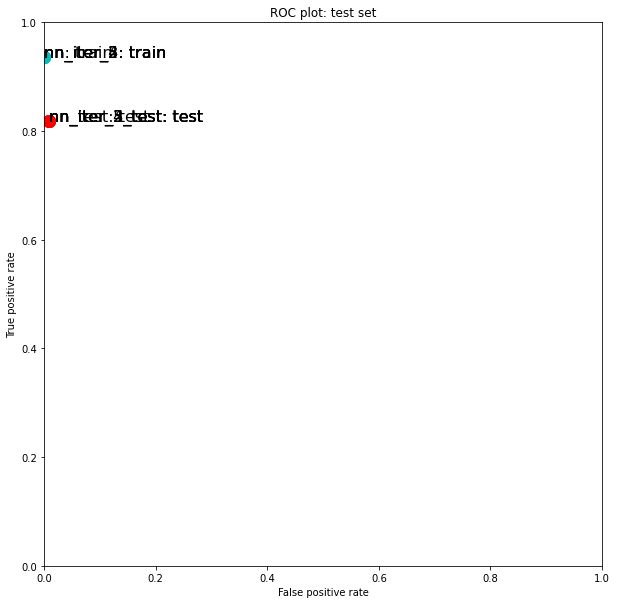

In [29]:
plt.figure(figsize=(10,10))

for fit in final_fits:
    if fit['set'] == 'train':
        color = 'co'
    else:
        color = 'ro'
    plt.plot(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], color, markersize=12)
    plt.text(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], fit['desc'] + ': ' + fit['set'], fontsize=16)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


In [30]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(max_iter=1000)
print(nn)
nn.fit(data_train, y_train)

nn_performance = BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance.compute_measures()
nn_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance.performance_measures)

nn_performance_test = BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test.compute_measures()
nn_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test.performance_measures)

nn_performance_test.img_indices()
nn_img_indices_to_view = nn_performance_test.image_indices

MLPClassifier(max_iter=1000)
TRAINING SET: 
{'Pos': 79, 'Neg': 4989, 'TP': 74, 'TN': 4989, 'FP': 0, 'FN': 5, 'Accuracy': 0.9990134175217048, 'Precision': 1.0, 'Recall': 0.9367088607594937, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 22, 'Neg': 1668, 'TP': 18, 'TN': 1653, 'FP': 15, 'FN': 4, 'Accuracy': 0.9887573964497042, 'Precision': 0.5454545454545454, 'Recall': 0.8181818181818182, 'desc': 'nn_test', 'set': 'test'}


/Users/janajasa/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:775: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.array(y > threshold, dtype=np.int)
/Users/janajasa/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for m

# SUBMISSION

### file paths and names:

In [31]:
submission_ci_path = 'test_data_for_grading/test_cropped_images/' # file path for cropped images for training
submission_l_file = 'test_data_for_grading/test_plane_labels.csv' # file path and file name for csv with labels

In [32]:
X_test_data, X_test_submission = process_raw_data(submission_l_file, submission_ci_path, my_random_seed=14, test=True)
print("Number of rows in the submission test set (should be 1,523): ")

/Users/janajasa/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
/Users/janajasa/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issub

First few lines of image labels: 
                   img_name
0  2016-08-02T13+50+24_430Z
1  2016-08-02T14+12+37_390Z
2  2016-08-03T12+32+21_790Z
3  2016-08-03T13+19+28_320Z
4  2016-08-05T15+24+58_670Z
Size of image label dataFrame: 
(1523, 1)
Shape of original feature representation: 
(1523, 15, 35)
Shape of flat feature representation: 
(1523, 525)
Shape of X_test for submission:
(1523, 525)
SUCCESS!
Number of rows in the submission test set (should be 1,523): 


### IMPORTANT CHECK: make sure that the number of columns in your training data is the same as the number of columns in this test submission!

In [33]:
print(data_train.shape)
print(X_test_data.shape)

(5068, 525)
(1523, 525)


Both the training set and submission test set have 525 columns. Success!

---

Choose a *single* model for your submission. In this code, I am choosing the Perceptron model fit, which is in the prc object. But you should choose the model that is performing the best for you!

In [34]:
# concatenate predictions to the id
X_test_submission["prediction"] = prc.predict(X_test_data)
# look at the proportion of positive predictions
print(X_test_submission['prediction'].mean())

0.017071569271175313


/Users/janajasa/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:309: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
/Users/janajasa/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more de

This is the proportion of predictions that have predicted that there is an airplane in the image.

In [35]:
print(X_test_submission.shape) # should be (1523, 2)

(1523, 2)


In [37]:
# export submission file as pdf
# CHANGE FILE PATH: 
X_test_submission.to_csv('my_second_airplane_submission.csv', index=False)